![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/regression/auto-ml-regression.png)

In [ ]:
!git pull

In [1]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from azureml.data.data_reference import DataReference
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import Model
from sklearn.metrics import mean_squared_error, r2_score

print(azureml.core.VERSION) #should be 1.0.57 or greater

1.0.57


In [2]:
ws = Workspace.from_config()
experiment_name = 'house_prices_regression'
project_folder = './sample_projects/house_prices_regression'
experiment = Experiment(ws, experiment_name)

## Data
This uses the AzureML datastore and dataset api's, as well as data manipulation, with keep_ and drop_ columns, and random_split.

In [10]:
datastore_name = 'edvanstorage__azureml'
dataset_path = 'boston_houses/boston_data.csv'
datastore = Datastore.get(ws, datastore_name)
data_reference = DataReference(datastore, data_reference_name="boston_data", path_on_datastore=dataset_path)
boston_ds = Dataset.get(ws, name='boston_housing_data')
boston_ds_2 = Dataset.Tabular.from_delimited_files(data_reference)
print(type(boston_ds))
print(type(boston_ds_2))

# boston_ds = boston_ds.drop_columns('Column1')
# boston_ds.to_pandas_dataframe().head(5)

NameError: name 'TabularDataset' is not defined

In [ ]:
b_train, b_test = boston_ds.random_split(0.2, seed=84)
X_train = b_train.drop_columns('Price')
y_train = b_train.keep_columns('Price')
X_test = b_test.drop_columns('Price')
y_test = b_test.keep_columns('Price')

## Remote compute
Setup the environments for remote compute, we might not need it...

In [ ]:
compute_target = ws.compute_targets['cpucluster']
run_config = RunConfiguration(framework="python")
run_config.target = compute_target
run_config.environment.docker.enabled = True
run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

dependencies = CondaDependencies.create(
    pip_packages=["scikit-learn", "scipy", "numpy"])
run_config.environment.python.conda_dependencies = dependencies

## Train

Instantiate an `AutoMLConfig` object to specify the settings for both local and remote runs and data used to run the experiment.

In [ ]:
aml_config = {"task": 'regression',
         "iteration_timeout_minutes": 10,
         "primary_metric": 'normalized_root_mean_squared_error',
         "debug_log": 'automl.log',
         "verbosity": logging.INFO,
         "enable_early_stopping": True,
         "X": X_train, 
         "y": y_train,
         "path": project_folder}

local_run = True
if local_run:
    numb_run_config = {
        'iterations': 10,
        'n_cross_validations': 5
    }
else:
    numb_run_config = {
        'iterations': 250,
        'n_cross_validations': 10
    }    
    remote_config = {
        'compute_target': compute_target,
        'run_configuration': run_config,
        'max_cores_per_iteration': 2,
        'max_concurrent_iterations': 10,
    }
    aml_config.update(remote_config)
aml_config.update(numb_run_config)
    
automl_config = AutoMLConfig(**aml_config)

In [ ]:
show_run = False
if 'compute_target' in aml_config:
    print(f"Running {aml_config['iterations']} iterations on remote compute (with {compute_target.vm_size} VM's), with {aml_config['n_cross_validations']}-fold cross validation.")
    show_run = False
else:
    print(f"Running {aml_config['iterations']} iterations on local compute, with {aml_config['n_cross_validations']}-fold cross validation.")
if not show_run:
    print("Not showing output here. Please run the Widget cell below.")
else:
    print("**********************************************************************************************")
run = experiment.submit(automl_config, show_output = show_run)

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show() 

In [77]:
from azureml.train.automl.run import AutoMLRun
if not run:
    run = AutoMLRun(experiment, run_id="AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578")
run

Experiment,Id,Type,Status,Details Page,Docs Page
house_prices_regression,AutoML_ee92b223-2212-4e27-b8e8-85e0ec1ab92e,automl,Completed,Link to Azure Portal,Link to Documentation



#### Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [78]:
children = list(run.get_children())
metricslist = {}
for r in children:
    properties = r.get_properties()
    metrics = {k: v for k, v in r.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
explained_variance,0.70,0.71,0.76,0.79,0.80,0.64,0.68,0.75,0.83,0.80
mean_absolute_error,2.98,3.00,2.50,2.34,2.24,3.00,3.00,2.63,2.05,2.25
mean_absolute_percentage_error,14.71,14.90,13.30,12.41,12.38,16.27,14.60,13.61,10.50,11.52
median_absolute_error,2.32,2.40,1.86,1.86,1.68,2.26,1.83,2.21,1.64,1.80
normalized_mean_absolute_error,0.07,0.07,0.06,0.05,0.05,0.07,0.07,0.06,0.05,0.05
normalized_median_absolute_error,0.05,0.06,0.04,0.04,0.04,0.05,0.04,0.05,0.04,0.04
normalized_root_mean_squared_error,0.09,0.09,0.08,0.08,0.08,0.09,0.10,0.09,0.07,0.08
normalized_root_mean_squared_log_error,0.10,0.10,0.11,0.08,0.08,0.09,0.10,0.09,0.07,0.08
r2_score,0.68,0.68,0.75,0.78,0.80,0.63,0.67,0.73,0.83,0.80
root_mean_squared_error,3.97,3.96,3.48,3.39,3.23,4.05,4.13,3.70,2.99,3.25


### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [80]:
best_run, fitted_model = run.get_output()
print(best_run)
print("----------------------------")
print(fitted_model)

Run(Experiment: house_prices_regression,
Id: AutoML_ee92b223-2212-4e27-b8e8-85e0ec1ab92e_8,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('4', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f3ad4478860>), ('LightGBMRegressor', LightGBMReg...         weights=[0.4444444444444444, 0.1111111111111111, 0.2222222222222222, 0.2222222222222222]))]),
          stddev=None)


#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [81]:
lookup_metric = "spearman_correlation"
best_run, fitted_model = run.get_output(metric = lookup_metric)
print(best_run)
print("----------------------------")
print(fitted_model)

Run(Experiment: house_prices_regression,
Id: AutoML_ee92b223-2212-4e27-b8e8-85e0ec1ab92e_2,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f3ad4432780>), ('ElasticNet', ElasticNet(alpha=0.15873684210526315, copy_X=True, fit_intercept=True,
      l1_ratio=0.6873684210526316, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))]),
          stddev=None)


In [82]:
iteration = 3
third_run, third_model = run.get_output(iteration = iteration)
print(third_run)
print("----------------------------")
print(third_model)

Run(Experiment: house_prices_regression,
Id: AutoML_ee92b223-2212-4e27-b8e8-85e0ec1ab92e_3,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f3ad4450a58>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_d...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)


## Test

Predict on training and test set, and calculate residual values.

In [83]:
X_train_pd = X_train.to_pandas_dataframe()
y_train_pd = y_train.to_pandas_dataframe().squeeze()
X_test_pd = X_test.to_pandas_dataframe()
y_test_pd = y_test.to_pandas_dataframe().squeeze()

y_pred_train = fitted_model.predict(X_train_pd)
y_residual_train = y_train_pd - y_pred_train

y_pred_test = fitted_model.predict(X_test_pd)
y_residual_test = y_test_pd - y_pred_test

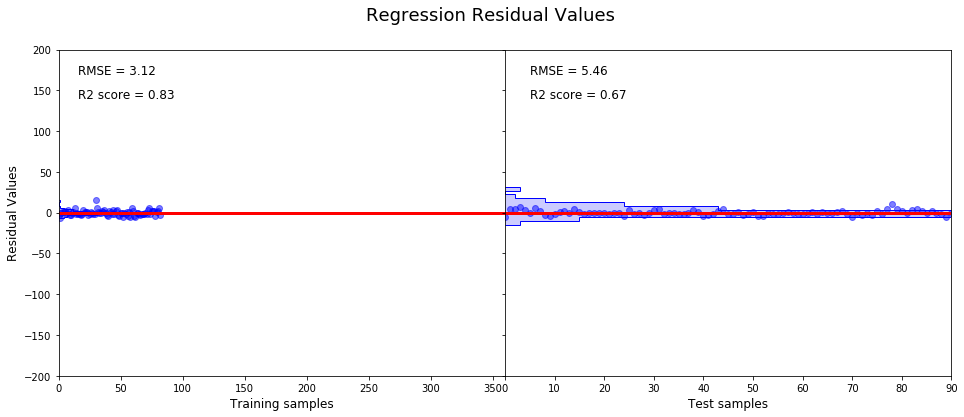

In [84]:
%matplotlib inline

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train_pd, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train_pd, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test_pd, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test_pd, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()

In [85]:
all_rmse = {}
for ite in range(aml_config['iterations']):
    try:
        i_run, model = run.get_output(iteration = ite)
        y_pred_test = model.predict(X_test_pd)
        all_rmse[ite] = np.sqrt(mean_squared_error(y_test_pd, y_pred_test))
    except Exception as e:
        print(f"Iteration {ite} gave an error {e}.")

In [86]:
all_rmse

{0: 6.064030259958559,
 1: 5.984815647740433,
 2: 5.46177975902496,
 3: 5.688519076706345,
 4: 5.756417944463689,
 5: 5.3185977081222475,
 6: 5.840916156715205,
 7: 5.911858699770488,
 8: 5.276200643129252,
 9: 5.174207673102299}

In [87]:
best_iteration = sorted(all_rmse, key=all_rmse.get, reverse=False)[0]
print(f'Best iteration is number {best_iteration}')
print("--------------")
best_test_run, best_test_model = run.get_output(iteration = best_iteration)
print(best_test_run)
print(best_test_run.get_file_names())
print("--------------")
print(best_test_model)
# print(best_test_model.get_model_path())

Best iteration is number 9
--------------
Run(Experiment: house_prices_regression,
Id: AutoML_ee92b223-2212-4e27-b8e8-85e0ec1ab92e_9,
Type: None,
Status: Completed)
['outputs/conda_env_v_1_0_0.yml', 'outputs/env_dependencies.json', 'outputs/model.pkl', 'outputs/scoring_file_v_1_0_0.py', 'predicted_true', 'residuals']
--------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('stackensembleregressor', StackEnsembleRegressor(base_learners=[('4', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f3ad42878d0>), ('LightGBMRegressor', LightGBMRegressor(bo...   random_state=None, selection='cyclic', tol=0.0001, verbose=0),
            training_cv_folds=5))]),
          stddev=None)


In [88]:
dependencies = run.get_run_sdk_dependencies(iteration = best_iteration)

In [89]:
for p in ['azureml-train-automl', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.57
azureml-core	1.0.57


In [90]:
myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn','py-xgboost==0.80'], pip_packages=['azureml-train-automl','azureml-core'])

conda_env_file_name = 'conda_dependencies.yml'
myenv.save_to_file('.', conda_env_file_name)

'conda_dependencies.yml'

## Register model and commit dependencies and score files first

Since the Release is triggered from a new version of the model, first the dependent files are updated in the repo, then the new model is registered, which triggers the release.

In [91]:
dep_changes = !git diff conda_dependencies.yml
score_changes = !git diff score.py
inference_changes = !git diff inference_config.json
aci_config_changes = !git diff aci_deployment_config.json
aks_config_changes = !git diff aks_deployment_config.json
if len(dep_changes) > 0:
    !git add conda_dependencies.yml
if len(score_changes) > 0:
    !git add score.py
if len(inference_changes) > 0:
    !git add inference_config.json
if len(aci_config_changes) > 0:
    !git add aci_deployment_config.json
if len(aks_config_changes) > 0:
    !git add aks_deployment_config.json
if len(dep_changes)+len(score_changes)+len(inference_changes)+len(aci_config_changes)+len(aks_config_changes)>0:
    print("Changes to commit. Committing and pushing now")
    !git commit -m "Commit from NB"
    !git push
else:
    print("No changes to commit.")

No changes to commit.


In [92]:
name = "house_prices_regression"
deploy = True
if deploy:
    model_registered = best_test_run.register_model(name, model_path='outputs/model.pkl')
else:
    # get the existing deployed model instead
    model_registered = Model(ws, name=name)
print(model_registered.name, model_registered.id, model_registered.version, sep='\t')

house_prices_regression	house_prices_regression:11	11


In [42]:
import json
import pickle
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model

# from inference_schema.schema_decorators import input_schema, output_schema
# from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
# from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType

input_sample = np.array({"data": [[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14]]})
output_sample = np.array([0])


def init():
    global model
    # This name is model.id of model that we want to deploy deserialize the model file back
    # into a sklearn model
    model_path = Model.get_model_path(model_name = 'house_prices_regression')
    print(model_path)
    model = joblib.load(model_path)


# @input_schema('data', NumpyParameterType(input_sample))
# @output_schema(NumpyParameterType(output_sample))
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)
        return result.tolist()
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result": result.tolist()})

In [43]:
test_data = {"data": [[ 0.00632, 18.0, 2.31, 0.0,0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98 ]]}


In [44]:
init()
run(json.dumps(test_data))

azureml-models/house_prices_regression/8/model.pkl


[29.65409319996861]

In [ ]:
from sklearn.externals import joblib
# model_path = Model.get_model_path(model_name="sample_projects/house_prices_regression")
joblib.load(model)

In [ ]:
from azureml.core.webservice import LocalWebservice
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig

environment = Environment("LocalDeploy")
environment.python.conda_dependencies = CondaDependencies("conda_dependencies.yml")

inference_config = InferenceConfig(entry_script="score.py", environment=environment)
deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(ws, "test", [best_test_model], inference_config, deployment_config)
local_service.wait_for_deployment()